In [3]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer


In [4]:
inflows = pd.read_parquet('data/ucsd-inflows.pqt')
outflows = pd.read_parquet('data/ucsd-outflows.pqt')

inflows.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,PAYCHECK,"2,477.0200",2022-03-18,PAYCHECK
1,0,acc_0,EXTERNAL_TRANSFER,100.0000,2022-10-25,EXTERNAL_TRANSFER
2,0,acc_0,MISCELLANEOUS,6.2900,2022-08-26,MISCELLANEOUS
3,0,acc_0,EXTERNAL_TRANSFER,277.0000,2022-06-03,EXTERNAL_TRANSFER
4,0,acc_0,EXTERNAL_TRANSFER,100.0000,2022-07-29,EXTERNAL_TRANSFER


In [3]:
outflows.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,LOAN,$900.60,2022-07-05,LOAN
1,0,acc_0,ATM_CASH,$80.00,2022-03-25,ATM_CASH
2,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,$18.42,2022-09-26,FOOD_AND_BEVERAGES
3,0,acc_0,LOAN,$634.00,2023-01-10,LOAN
4,0,acc_0,Buffalo Wild Wings,$26.47,2022-09-12,FOOD_AND_BEVERAGES


In [4]:
print(f' There are \n - {outflows.prism_consumer_id.unique().shape[0]} consumers \n - {outflows.prism_account_id.unique().shape[0]} accounts')

outflows.groupby('prism_consumer_id').count()[['prism_account_id']].head()

 There are 
 - 2968 consumers 
 - 4622 accounts


,prism_account_id
prism_consumer_id,
0,645
2,638
4,705
7,322
9,2093


In [5]:
outflows.groupby('prism_account_id').count()[['prism_consumer_id']]

,prism_consumer_id
prism_account_id,
acc_0,644
acc_1,1
acc_100,1736
acc_1005,115
acc_1006,2
...,...
acc_986,20
acc_987,11
acc_988,6


## Most Commmon Merchants per Category

In [6]:
outflows.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,LOAN,$900.60,2022-07-05,LOAN
1,0,acc_0,ATM_CASH,$80.00,2022-03-25,ATM_CASH
2,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,$18.42,2022-09-26,FOOD_AND_BEVERAGES
3,0,acc_0,LOAN,$634.00,2023-01-10,LOAN
4,0,acc_0,Buffalo Wild Wings,$26.47,2022-09-12,FOOD_AND_BEVERAGES


In [5]:
# Finding most common merchant per category.
mcm_all = outflows.groupby('category')['memo'].agg(lambda x: x.value_counts().idxmax()).reset_index()

mcm_removed = mcm_all[mcm_all['category'] != mcm_all['memo']]

mcm_all.head(), mcm_removed.head()


(          category             memo
 0     ACCOUNT_FEES     ACCOUNT_FEES
 1         ATM_CASH         ATM_CASH
 2       AUTOMOTIVE       AUTOMOTIVE
 3        AUTO_LOAN        AUTO_LOAN
 4  BILLS_UTILITIES  BILLS_UTILITIES,
                category                                memo
 8             EDUCATION             Teacherspayteachers.com
 12   FOOD_AND_BEVERAGES                          McDonald's
 13  GENERAL_MERCHANDISE                              Amazon
 15            GROCERIES                             Walmart
 20             MORTGAGE  HUNTINGTON MORTG ONLINE PMT XXXXXX)

In [8]:
# preprocessed by removing all records where category == memo (does not give us info on actual merchant)
mcm_preprocessed = outflows[outflows['category'] != outflows['memo']]

# relevant because finding most common merchant per category on records that give us actual info
mcm_relevant = mcm_preprocessed.groupby('category')['memo'].agg(lambda x: x.value_counts().idxmax()).reset_index()


mcm_relevant.head()

,category,memo
0,EDUCATION,Teacherspayteachers.com
1,FOOD_AND_BEVERAGES,McDonald's
2,GENERAL_MERCHANDISE,Amazon
3,GROCERIES,Walmart
4,MORTGAGE,HUNTINGTON MORTG ONLINE PMT XXXXXX


## Normal Statistics
- move to quantile per category

In [9]:
amount_stats = outflows.groupby('category')['amount'].agg(
    mean_amount=('mean'),
    min_amount=('min'),
    max_amount=('max'),
    total_amount=('sum'),
).reset_index()

amount_stats['% total'] = amount_stats['total_amount'] / sum(amount_stats['total_amount'])

amount_stats.head()

,category,mean_amount,min_amount,max_amount,total_amount,% total
0,ACCOUNT_FEES,$16.68,$0.00,"$17,241.28","$625,715.21",$0.00
1,ATM_CASH,$461.57,$0.00,"$461,421.00","$54,304,232.38",$0.14
2,AUTOMOTIVE,$43.64,$0.00,"$69,588.33","$9,102,938.62",$0.02
3,AUTO_LOAN,$200.00,$200.00,$200.00,$200.00,$0.00
4,BILLS_UTILITIES,$80.43,$7.21,$151.95,"$1,849.94",$0.00


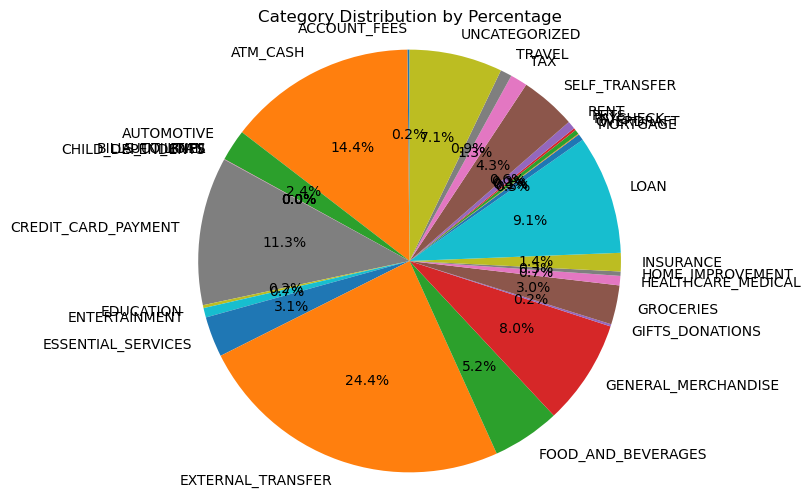

In [10]:
plt.figure(figsize=(6, 6))
plt.pie(amount_stats['% total'], labels=amount_stats['category'], autopct='%1.1f%%', startangle=90)
plt.title('Category Distribution by Percentage')
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is drawn as a circle.
plt.show()

In [11]:
outflows.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,LOAN,$900.60,2022-07-05,LOAN
1,0,acc_0,ATM_CASH,$80.00,2022-03-25,ATM_CASH
2,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,$18.42,2022-09-26,FOOD_AND_BEVERAGES
3,0,acc_0,LOAN,$634.00,2023-01-10,LOAN
4,0,acc_0,Buffalo Wild Wings,$26.47,2022-09-12,FOOD_AND_BEVERAGES


# Consumer ID 0 stats

In [12]:
outflows['posted_date'] = pd.to_datetime(outflows['posted_date'])
outflows = outflows.sort_values(by='posted_date', ascending=True)


In [13]:
outflows_0 = outflows[outflows['prism_consumer_id'] == 0]

outflows_0_loan = outflows_0[outflows['memo'] == 'LOAN']
outflows_0_loan.head()


/tmp/ipykernel_272/2065683930.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outflows_0_loan = outflows_0[outflows['memo'] == 'LOAN']


,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
323,0,acc_0,LOAN,$520.00,2022-03-01,LOAN
247,0,acc_0,LOAN,$924.29,2022-03-02,LOAN
258,0,acc_0,LOAN,$520.00,2022-04-01,LOAN
130,0,acc_0,LOAN,$924.29,2022-04-04,LOAN
87,0,acc_0,LOAN,$520.00,2022-05-02,LOAN


/tmp/ipykernel_272/2006446674.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outflows_0_loan = outflows_0[outflows['memo'] == 'LOAN']


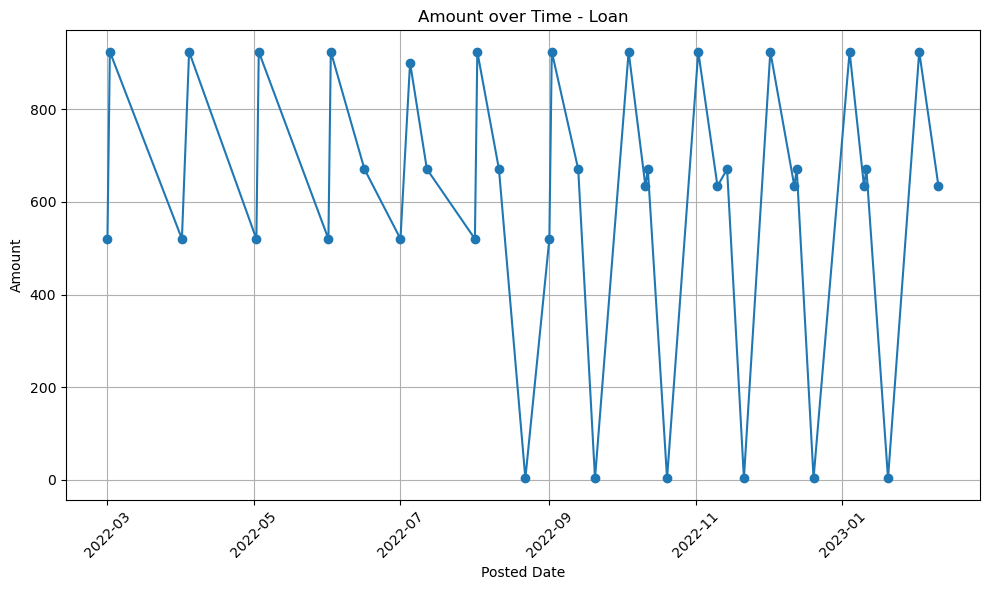

In [14]:
outflows_0_loan = outflows_0[outflows['memo'] == 'LOAN']
plt.figure(figsize=(10, 6))
plt.plot(outflows_0_loan['posted_date'], outflows_0_loan['amount'], marker='o')
plt.title('Amount over Time - Loan')
plt.xlabel('Posted Date')
plt.ylabel('Amount')
plt.grid(True)  # Add grid for better readability
plt.xticks(rotation=45)  # Rotate date labels for better readability

# Show the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()


# Consumer ID n Stats

In [15]:
memos = outflows.memo.unique()
print(memos)

ids = (outflows.prism_consumer_id.min(), outflows.prism_consumer_id.max())
ids

['ACCOUNT_FEES' 'ATM_CASH' 'EXTERNAL_TRANSFER' ... 'Angie S Soul Food Bb'
 'Ubr* Pending.Uber.com San Franciscocaus' 'YSI*Canyon House CARD#XXXX']


(0, 5943)

In [16]:
# Fill in here:
memo_type = 'ATM_CASH'
n = np.random.choice(outflows['prism_consumer_id'].unique())

outflows_n = outflows[outflows['prism_consumer_id'] == n]

outflows_ntype = outflows_n[outflows_n['memo'] == memo_type]

outflows_ntype.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
1162946,2784,acc_6367,ATM_CASH,$755.35,2023-01-09,ATM_CASH
1163457,2784,acc_6367,ATM_CASH,$245.51,2023-01-23,ATM_CASH
1163279,2784,acc_6367,ATM_CASH,$245.51,2023-02-06,ATM_CASH
1163555,2784,acc_6367,ATM_CASH,$245.51,2023-02-21,ATM_CASH
1162869,2784,acc_6367,ATM_CASH,$120.36,2023-03-06,ATM_CASH


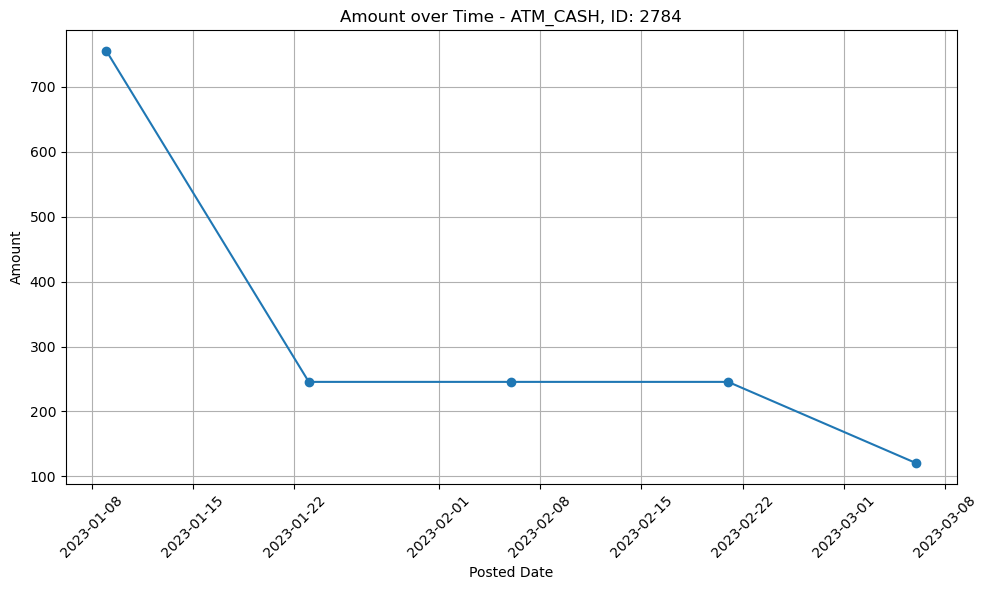

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(outflows_ntype['posted_date'], outflows_ntype['amount'], marker='o')
plt.title('Amount over Time - ' + memo_type + ', ID: ' + str(n))
plt.xlabel('Posted Date')
plt.ylabel('Amount')
plt.grid(True)  # Add grid for better readability
plt.xticks(rotation=45)  # Rotate date labels for better readability

# Show the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

In [18]:
np.percentile(outflows['amount'], [25, 75])

array([ 9.63, 66.36])

In [19]:
num_bins = 4
hist, bins = np.histogram(outflows.amount, bins= num_bins)

print(bins)
print(hist)

[     0.     163713.3025 327426.605  491139.9075 654853.21  ]
[2597445      34       7       2]


- majority of data < 163,713.3025.
- reasons for big expense?

In [20]:
expensive_outflows = outflows[outflows['amount'] > 163713]
expensive_outflows.shape

(43, 6)

In [21]:
eflows = expensive_outflows.groupby('category')[['amount']].sum().reset_index()
eflows['% total'] = eflows['amount'] / eflows['amount'].sum()
eflows

,category,amount,% total
0,ATM_CASH,"$2,399,990.80",$0.21
1,CREDIT_CARD_PAYMENT,"$166,149.40",$0.01
2,EXTERNAL_TRANSFER,"$4,359,053.88",$0.38
3,FOOD_AND_BEVERAGES,"$625,310.60",$0.05
4,GENERAL_MERCHANDISE,"$280,171.35",$0.02
5,LOAN,"$1,482,678.74",$0.13
6,SELF_TRANSFER,"$1,480,742.38",$0.13
7,TAX,"$218,402.00",$0.02
8,UNCATEGORIZED,"$555,208.81",$0.05


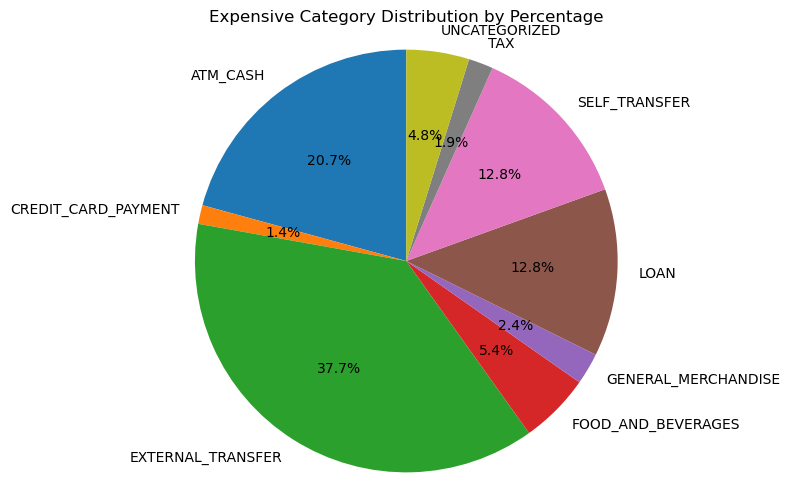

In [22]:
plt.figure(figsize=(6, 6))
plt.pie(eflows['% total'], labels=eflows['category'], autopct='%1.1f%%', startangle=90)
plt.title('Expensive Category Distribution by Percentage')
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is drawn as a circle.
plt.show()

# Week 2 - Sampling by Consumer

In [23]:
outflows = outflows.reset_index(drop=True)
outflows.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,1603,acc_4443,ACCOUNT_FEES,$10.00,2017-12-29,ACCOUNT_FEES
1,1603,acc_4440,ACCOUNT_FEES,$14.00,2017-12-29,ACCOUNT_FEES
2,1603,acc_4444,ACCOUNT_FEES,$2.50,2018-01-02,ACCOUNT_FEES
3,1603,acc_4444,ATM_CASH,$302.50,2018-01-02,ATM_CASH
4,1603,acc_4444,EXTERNAL_TRANSFER,"$4,000.00",2018-01-03,EXTERNAL_TRANSFER


In [24]:
ids = outflows.prism_consumer_id.unique()
ids

array([1603,  596,  141, ..., 1630, 1529, 1531])

In [25]:
n = outflows.shape[0]
n

2597488

In [26]:
training_size = int(n * 0.80)
test_size = n - training_size

####
training_size = 400
test_size = 100
####

print(f'training_size = {training_size}, test_size = {test_size}')

training_size = 400, test_size = 100


In [27]:
x = np.random.choice(outflows[outflows.prism_consumer_id == np.random.choice(ids)].index)
x

1827326

In [28]:
training_idx = []

for _ in range(training_size):
    curr = np.random.choice(outflows[outflows.prism_consumer_id == np.random.choice(ids)].index)
    training_idx.append(curr)

train_df = outflows.iloc[training_idx]

print(f'Training Data is {train_df.shape[0]} instances')
train_df.head()


Training Data is 400 instances


,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
1695710,1993,acc_5571,CREDIT_CARD_PAYMENT,"$2,272.17",2022-08-17,CREDIT_CARD_PAYMENT
517681,1852,acc_5134,LOAN,$348.40,2021-08-18,LOAN
823480,186,acc_536,DEBIT CARD PURCHASE NO DROUGHT BREWING CO SPOK...,$76.24,2021-12-14,FOOD_AND_BEVERAGES
2266973,5926,acc_9509,ACCOUNT_FEES,$2.50,2022-12-23,ACCOUNT_FEES
1229131,1266,acc_3565,ENTERTAINMENT,$3.99,2022-04-26,ENTERTAINMENT


In [29]:
test_idx = []

for i in range(test_size):
    curr = np.random.choice(outflows[outflows.prism_consumer_id == np.random.choice(ids)].index)
    test_idx.append(curr)

    if i % 50000 == 0:
        print(f'{i} iteration')

test_df = outflows.iloc[test_idx]

print(f'Test Data is {test_df.shape[0]} instances')
test_df.head()


0 iteration
Test Data is 100 instances


,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
95414,473,acc_1389,ESSENTIAL_SERVICES,$122.00,2020-11-18,ESSENTIAL_SERVICES
1371739,4109,acc_7692,CREDIT_CARD_PAYMENT,$50.00,2022-06-03,CREDIT_CARD_PAYMENT
771389,4131,acc_7714,ATM_CASH,$350.00,2021-11-26,ATM_CASH
2182605,2769,acc_6352,Purchase JACK'S #171 Q08,$7.14,2022-11-30,FOOD_AND_BEVERAGES
2572649,3145,acc_6728,AUTOMOTIVE,$11.28,2023-05-28,AUTOMOTIVE


In [30]:
print(f'# of unique IDS: {len(outflows.prism_consumer_id.unique())}, # of unique test IDS: {len(test_df.prism_consumer_id.unique())}')

# of unique IDS: 2968, # of unique test IDS: 98


In [31]:
outflows.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,prism_consumer_id,amount,posted_date
count,2597488.00000,2597488.00000,2597488.00000
mean,3084.22934,145.12640,.5f
min,0.00000,0.00000,.5f
25%,1369.00000,9.63000,.5f
50%,3245.00000,24.26000,.5f
75%,4733.00000,66.36000,.5f
max,5943.00000,654853.21000,.5f
std,1820.57135,1697.87473,nan


In [32]:
train_df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,prism_consumer_id,amount,posted_date
count,400.00000,400.00000,400.00000
mean,2931.32000,151.29340,.5f
min,2.00000,0.01000,.5f
25%,1428.50000,9.99000,.5f
50%,2963.50000,25.00000,.5f
75%,4467.00000,84.91000,.5f
max,5926.00000,5453.20000,.5f
std,1722.23532,473.71416,nan


In [33]:
test_df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,prism_consumer_id,amount,posted_date
count,100.00000,100.00000,100.00000
mean,3146.20000,102.98900,.5f
min,26.00000,0.25000,.5f
25%,2014.50000,8.33250,.5f
50%,3261.00000,25.00000,.5f
75%,4315.75000,94.25500,.5f
max,5913.00000,1502.75000,.5f
std,1643.05808,212.91792,nan


(array([12.,  4.,  8.,  6., 12., 16., 12., 13.,  5., 12.]),
 array([  26. ,  614.7, 1203.4, 1792.1, 2380.8, 2969.5, 3558.2, 4146.9,
        4735.6, 5324.3, 5913. ]),
 <BarContainer object of 10 artists>)

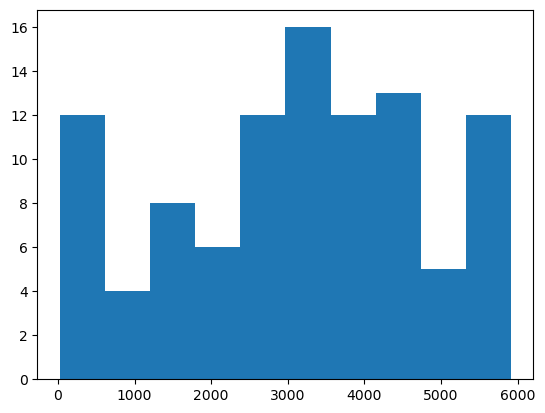

In [34]:
plt.hist(test_df.prism_consumer_id)

# Data Cleaning / Processing

In [35]:
outflows.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,1603,acc_4443,ACCOUNT_FEES,$10.00,2017-12-29,ACCOUNT_FEES
1,1603,acc_4440,ACCOUNT_FEES,$14.00,2017-12-29,ACCOUNT_FEES
2,1603,acc_4444,ACCOUNT_FEES,$2.50,2018-01-02,ACCOUNT_FEES
3,1603,acc_4444,ATM_CASH,$302.50,2018-01-02,ATM_CASH
4,1603,acc_4444,EXTERNAL_TRANSFER,"$4,000.00",2018-01-03,EXTERNAL_TRANSFER


In [36]:
outflows.category.unique()

array(['ACCOUNT_FEES', 'ATM_CASH', 'EXTERNAL_TRANSFER',
       'CREDIT_CARD_PAYMENT', 'GENERAL_MERCHANDISE', 'ENTERTAINMENT',
       'LOAN', 'INSURANCE', 'UNCATEGORIZED', 'ESSENTIAL_SERVICES',
       'AUTOMOTIVE', 'TAX', 'HEALTHCARE_MEDICAL', 'TRAVEL', 'GROCERIES',
       'FOOD_AND_BEVERAGES', 'HOME_IMPROVEMENT', 'SELF_TRANSFER',
       'OVERDRAFT', 'PETS', 'EDUCATION', 'GIFTS_DONATIONS', 'MORTGAGE',
       'RENT', 'CHILD_DEPENDENTS', 'BNPL', 'PAYCHECK', 'AUTO_LOAN',
       'BILLS_UTILITIES'], dtype=object)

In [37]:
loans = outflows[outflows.category == 'LOAN'].reset_index(drop=True)
loans = loans[loans.memo != 'LOAN']
loans

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category


In [38]:
outflows[(outflows.category == 'LOAN') & (outflows.memo != 'LOAN')]

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category


In [39]:
x = set(outflows[outflows.memo != 'LOAN'].index)
y = set(outflows[outflows.category == 'LOAN'].index)

In [40]:
 x & y

set()

In [41]:
outflows[(outflows.category == 'LOAN') & (outflows.memo == 'LOAN')].shape[0]

90945

In [42]:
outflows[outflows.category == 'LOAN'].shape[0]

90945

In [43]:
outflows.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,1603,acc_4443,ACCOUNT_FEES,$10.00,2017-12-29,ACCOUNT_FEES
1,1603,acc_4440,ACCOUNT_FEES,$14.00,2017-12-29,ACCOUNT_FEES
2,1603,acc_4444,ACCOUNT_FEES,$2.50,2018-01-02,ACCOUNT_FEES
3,1603,acc_4444,ATM_CASH,$302.50,2018-01-02,ATM_CASH
4,1603,acc_4444,EXTERNAL_TRANSFER,"$4,000.00",2018-01-03,EXTERNAL_TRANSFER


# Week 3 - Cleaning Memo Fields

In [44]:
outflows.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,1603,acc_4443,ACCOUNT_FEES,$10.00,2017-12-29,ACCOUNT_FEES
1,1603,acc_4440,ACCOUNT_FEES,$14.00,2017-12-29,ACCOUNT_FEES
2,1603,acc_4444,ACCOUNT_FEES,$2.50,2018-01-02,ACCOUNT_FEES
3,1603,acc_4444,ATM_CASH,$302.50,2018-01-02,ATM_CASH
4,1603,acc_4444,EXTERNAL_TRANSFER,"$4,000.00",2018-01-03,EXTERNAL_TRANSFER


In [45]:
f = open('memo_original.txt', 'w')
inspect = outflows.memo.unique()

f.write(',\n'.join([str(x) for x in sorted(inspect)]))
f.close()



In [46]:
print(f'Before cleaning, {outflows.memo.nunique()} memos')               

Before cleaning, 528786 memos


### Potential removals:
- stop words
- special characters (#, -, _, +, /)
- XXXX occurrences
- lowercase characters
  
  

In [47]:
def clean_memo(memo): 
    sw = ['payment', 'transaction', 'deposit', 'withdrawal', 'transfer', 'credit', 'debit', 'refund', 'fee', 'charge', 'purchase', 'atm']

    # lowercase
    memo = memo.lower()

    memo = re.sub(r'card \d+ #\w+|mcc \w+', '', memo)
       
    memo = re.sub(r'\(\d{3}\)\s*\d{3}-\w+', '', memo)  # remove phone #s like (800) 544-XXXX
    memo = re.sub(r'#\w{3,}', '', memo)                # Matches patterns like #XXXX
    memo = re.sub(r'mcc:\s*\w+', '', memo)             # Matches patterns like MCC: XXXX

    memo = re.sub(r'[\#\-\_\+\/\$]', ' ', memo)          # turn special characters into ' '
    memo = re.sub(r'\s+', ' ', memo)                   # removes multiple spaces

    memo = re.sub(r'\b(\w+)\s+(\w+)\b', r'\1\2', memo) # merge split adjacent words
    memo = re.sub(r'\s+', ' ', memo)                   # re-clean extra spaces

    memo = re.sub(r'x{3,}', '', memo)                   # remove instances of XXX+

    # location stanrdardization (Do NOT need location info?)
    # memo = re.sub(r'\bst\b', 'street', memo)
    # memo = re.sub(r'\brd\b', 'road', memo)
    # memo = re.sub(r'\bblvd\b', 'boulevard', memo)
    # memo = re.sub(r'\bave\b', 'avenue', memo)

    # removing location info
    memo = re.sub(r'\b(\d+\w*)\b', '', memo)  # remove house numbers
    memo = re.sub(r'(street|st|road|rd|blvd|avenue|ave|us|highway|hwy|north|south|east|west|fl|ca)\b', '', memo) 

    memo_tks = memo.split()
    new_memo = ' '.join([word for word in memo_tks if word not in sw])

    return new_memo.strip()

    

In [57]:
def clean_memo(memo):
    sw = ['payment', 'transaction', 'deposit', 'withdrawal', 'transfer', 'credit', 'debit', 'refund', 'fee', 'charge', 'purchase', 'atm']

    memo = memo.lower()

    memo = re.sub(r'^#\w{6,}', '', memo) # remove the leadings X's (ex. #XXXX)
    memo = re.sub(r'\*\w{5,}', '', memo) # remove the leading alphanumeric ids
    # memo = re.sub(r'\b\w*(www\.|\.com)\w*\b', '', memo) # removing any links or urls
    memo = re.sub(r'\b\w*(www\.)\w*\b', '', memo) # removing any links or urls
    memo = re.sub(r'(#|xxx).*$', '', memo) # removes the trailing X's

    memo = re.sub(r'[0-9]{2}((-|/)[0-9]{2,4}){1,2}', '', memo) # remove dates

    memo = re.sub(r'[^\w\s-]', ' ', memo)  # replace special characters with single space
    memo = re.sub(r'([a-z]+)\s{0,1}-\s{0,1}([a-z]+)', r'\1\2', memo) # replace '-' w/ ''
    memo = re.sub(r'\s+', ' ', memo)  # remove multiple spaces

    return memo.strip()

# 99-cents -> 99 cents
# wal-mart -> wal mart

# WAL WAL-MART #XXXX XXXXXX STREET
# WAL WAL-MART


In [68]:
def clean_memo(memo):
    sw = ['payment', 'transaction', 'deposit', 'withdrawal', 'transfer', 'credit', 'debit', 'refund', 'fee', 'charge', 'purchase', 'atm', 'checkcard']

    memo = memo.lower()

    memo = re.sub(r'x{3,}', '', memo) # remove the X's (ex. #XXXX)
    memo = re.sub(r'^#[a-z0-9]+', '', memo) # remove the #smth @ start of memo
    memo = re.sub(r'(www\.|\.com)', '', memo) # removing any links or urls

    memo = re.sub(r'[0-9x]{2}((-|/)[0-9x]{2,4}){1,2}', '', memo) # remove dates

    memo = re.sub(r'[^\w\s-]', ' ', memo)  # replace special characters with single space
    memo = re.sub(r'([a-z]+)\s{0,1}-\s{0,1}([a-z]+)', r'\1\2', memo) # replace '-' w/ ''
    memo = re.sub(r'\s+', ' ', memo)  # remove multiple spaces

    return memo.strip()

# 99-cents -> 99 cents
# wal-mart -> wal mart

# WAL WAL-MART #XXXX XXXXXX STREET
# WAL WAL-MART


In [69]:
outflows['clean_memo'] = outflows.apply(lambda row: clean_memo(row.memo) if row.memo != row.category else row.memo, axis=1) # outflows.memo.apply(clean_memo)
outflows.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,clean_memo
0,1603,acc_4443,ACCOUNT_FEES,$10.00,2017-12-29,ACCOUNT_FEES,ACCOUNT_FEES
1,1603,acc_4440,ACCOUNT_FEES,$14.00,2017-12-29,ACCOUNT_FEES,ACCOUNT_FEES
2,1603,acc_4444,ACCOUNT_FEES,$2.50,2018-01-02,ACCOUNT_FEES,ACCOUNT_FEES
3,1603,acc_4444,ATM_CASH,$302.50,2018-01-02,ATM_CASH,ATM_CASH
4,1603,acc_4444,EXTERNAL_TRANSFER,"$4,000.00",2018-01-03,EXTERNAL_TRANSFER,EXTERNAL_TRANSFER


In [70]:
walmart = outflows[outflows.clean_memo.str.startswith('wal') & outflows.clean_memo.str.endswith('mart')]

walmart.clean_memo.unique(), (walmart.clean_memo == 'walmart').sum()

(array(['walmart', 'wal mart', 'walmart walmart', 'waldo mart',
        'wally s lucky mart'], dtype=object),
 32154)

In [71]:
def clean_memo_pt2(memo):
    merchant_map = {'wal walmart': 'walmart', 'walmart walmart': 'walmart', 'wal mart': 'walmart'}

    if memo in merchant_map: return merchant_map[memo]
    return memo
    

In [72]:
outflows.clean_memo = outflows.clean_memo.apply(clean_memo_pt2)
outflows.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,clean_memo
0,1603,acc_4443,ACCOUNT_FEES,$10.00,2017-12-29,ACCOUNT_FEES,ACCOUNT_FEES
1,1603,acc_4440,ACCOUNT_FEES,$14.00,2017-12-29,ACCOUNT_FEES,ACCOUNT_FEES
2,1603,acc_4444,ACCOUNT_FEES,$2.50,2018-01-02,ACCOUNT_FEES,ACCOUNT_FEES
3,1603,acc_4444,ATM_CASH,$302.50,2018-01-02,ATM_CASH,ATM_CASH
4,1603,acc_4444,EXTERNAL_TRANSFER,"$4,000.00",2018-01-03,EXTERNAL_TRANSFER,EXTERNAL_TRANSFER


In [52]:
misses = outflows[outflows.clean_memo == ''].index

for i in range(10):
    print(outflows.iloc[misses[i]].memo)

XXXXX EL SEGUNDO XXXXA
XXXX FOREVER 21
XXXX FOREVER 21
XXXXX PROMENADEATWEST
XXXX FOREVER 21
XXXX JNN ALABASTER
XXXXXX POS PURCHASE 03/01 DELTA WEST MILFO WEST MILFORD NJ XXXXXXXX XXXXXX
XXXXXX POS PURCHASE 02/28 FLIK BAYER 11 CONVENT STATI NJ XXXXXXXX XXXXXX
XXXXXX POS PURCHASE 03/01 ACME XXXX OAK RIDGE NJ XXXXXXXX XXXXXX
XXXXXX POS PURCHASE 02/28 FLIK BAYER 11 CONVENT STATI NJ XXXXXXXX XXXXXX


In [75]:
outflows[outflows.clean_memo.str.contains('checkcard')].head(10).clean_memo.tolist()

['checkcard the school box 002 town kennesaw ga',
 'checkcard chewy fl',
 'checkcard fermi iii newport mi',
 'checkcard sp doggovinci toronto on',
 'checkcard lee s market inc berlin chartemi',
 'checkcard by my side holste mi',
 'checkcard new jakes liquor monroe mi',
 'checkcard fermi iii newport mi',
 'checkcard the mitten cafe newport mi',
 'checkcard the mitten cafe newport mi']

In [91]:
print(f'After initial cleaning, {outflows.clean_memo.nunique()} memos (fixed {outflows.memo.nunique() - outflows.clean_memo.nunique()})')

After initial cleaning, 147537 memos (fixed 381249)


In [92]:
f = open('memo_cleaning.txt', 'w')
inspect = outflows.clean_memo.unique()

f.write(',\n'.join([str(x) for x in sorted(inspect)]))
f.close()



In [98]:
outflows[outflows.memo.str.lower().str.contains('intuitive')]

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,clean_memo
2556551,2777,acc_6360,Etsy.com - IntuitiveArt718-XXXXXXX,$28.20,2023-05-10,GENERAL_MERCHANDISE,- intuitiveart718-
2566821,2777,acc_6360,Etsy.com - IntuitiveArt718-XXXXXXX,$38.09,2023-05-21,GENERAL_MERCHANDISE,- intuitiveart718-


In [68]:
outflows.category.unique()

array(['ACCOUNT_FEES', 'ATM_CASH', 'EXTERNAL_TRANSFER',
       'CREDIT_CARD_PAYMENT', 'GENERAL_MERCHANDISE', 'ENTERTAINMENT',
       'LOAN', 'INSURANCE', 'UNCATEGORIZED', 'ESSENTIAL_SERVICES',
       'AUTOMOTIVE', 'TAX', 'HEALTHCARE_MEDICAL', 'TRAVEL', 'GROCERIES',
       'FOOD_AND_BEVERAGES', 'HOME_IMPROVEMENT', 'SELF_TRANSFER',
       'OVERDRAFT', 'PETS', 'EDUCATION', 'GIFTS_DONATIONS', 'MORTGAGE',
       'RENT', 'CHILD_DEPENDENTS', 'BNPL', 'PAYCHECK', 'AUTO_LOAN',
       'BILLS_UTILITIES'], dtype=object)

In [51]:
# for cat in outflows.category.unique():
#     sub = outflows[outflows.category == cat]
#     unique_memos = sorted(sub.memo.unique())

#     title = 'original_data/' + cat + '_original.txt'

#     with open(title, 'w') as f:
#         inspect = outflows.clean_memo.unique()

#         f.write(',\n'.join([str(x) for x in sorted(inspect)]))


# TF/IDF, Create Date / Amount based attributes

### Potential Date and Amount Features

- 0/1 Weekday / Weekend
- 0/1 if cash even amount (ATM quick cash or whole dollar)
- 0-11 month #
- 0-6 day of week (monday -> sundayy)
- signify small medium large purchases (ex. 0-100, 101-500, 500-2000, 2000-10000, 10000->)

Extra:
- season / quarter of the year
- first week / last week of the month
- 

### TF/IDF Summing
Summing the columns of the tfidf_df DataFrame provides information about the overall importance of each term across all documents. Specifically:

<strong>Higher Sum</strong>: A higher sum for a column indicates that the corresponding term appears frequently in multiple documents or has higher importance in the context of the TF-IDF calculation.

<strong>Lower Sum</strong>: A lower sum indicates that the term appears less frequently across documents or has lower importance.

In [126]:
outflows.posted_date = pd.to_datetime(outflows.posted_date)

relevant_of = outflows[outflows.category != outflows.memo].reset_index(drop=True)
relevant_of.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.4200,2022-09-26,FOOD_AND_BEVERAGES
1,0,acc_0,Buffalo Wild Wings,26.4700,2022-09-12,FOOD_AND_BEVERAGES
2,0,acc_0,Oculus CA 04/16,11.7300,2022-04-18,GENERAL_MERCHANDISE
3,0,acc_0,LOS GIRASOLES STOW OH 03/08,30.0400,2022-03-09,FOOD_AND_BEVERAGES
4,0,acc_0,BUZZIS LAUNDRY 1 OH 03/28,4.1600,2022-03-29,GENERAL_MERCHANDISE


In [127]:
num_bins = 10
relevant_of['bin_num'] = pd.qcut(relevant_of.amount, q=num_bins, labels = [f'bin_{num}' for num in range(1, num_bins + 1)])



In [128]:
def amount_splitter(amnt):
    if amnt < 100: return 1
    if amnt < 500: return 2
    if amnt < 2000: return 3
    if amnt < 10000: return 4
    return 5

In [129]:
# outflows['day_of_week'] = outflows.posted_date.dt.weekday
relevant_of['is_weekend'] = (relevant_of.posted_date.dt.weekday >= 5).astype(int)
# outflows['month_num'] = outflows.posted_date.dt.month
relevant_of['is_even_amount'] = relevant_of.amount.apply(lambda x: 1 if x % 1 == 0 and x % 5 == 0 else 0)
# relevant_of['amount_scale'] = relevant_of.amount.apply(amount_splitter)

relevant_of.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,bin_num,is_weekend,is_even_amount
0,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.4200,2022-09-26,FOOD_AND_BEVERAGES,bin_5,0,0
1,0,acc_0,Buffalo Wild Wings,26.4700,2022-09-12,FOOD_AND_BEVERAGES,bin_7,0,0
2,0,acc_0,Oculus CA 04/16,11.7300,2022-04-18,GENERAL_MERCHANDISE,bin_4,0,0
3,0,acc_0,LOS GIRASOLES STOW OH 03/08,30.0400,2022-03-09,FOOD_AND_BEVERAGES,bin_7,0,0
4,0,acc_0,BUZZIS LAUNDRY 1 OH 03/28,4.1600,2022-03-29,GENERAL_MERCHANDISE,bin_2,0,0


In [130]:
relevant_of.posted_date[0].month

9

In [131]:
relevant_of.amount[0]

18.42

In [132]:
def clean_memo(memo):
    sw = ['payment', 'transaction', 'deposit', 'withdrawal', 'transfer', 'credit', 'debit', 'refund', 'fee', 'charge', 'purchase', 'atm', 'checkcard']

    memo = memo.lower()

    memo = re.sub(r'[0-9]{3,}', '', memo) # remove instances of numbers more than 3 repeated
    
    memo = re.sub(r'x{3,}', '', memo) # remove the X's (ex. #XXXX)
    memo = re.sub(r'^#[a-z0-9]+', '', memo) # remove the #smth @ start of memo
    memo = re.sub(r'(www\.|\.com)', '', memo) # removing any links or urls

    memo = re.sub(r'[0-9x]{2}((-|/)[0-9x]{2,4}){1,2}', '', memo) # remove dates

    memo = re.sub(r'[^\w\s-]', ' ', memo)  # replace special characters with single space
    memo = re.sub(r'([a-z]+)\s{0,1}-\s{0,1}([a-z]+)', r'\1\2', memo) # replace '-' w/ ''
    memo = re.sub(r'\s+', ' ', memo)  # remove multiple spaces

    # location
    state_abbreviations = [
        "al", "ak", "az", "ar", "ca", "co", "ct", "de", "fl", "ga", 
        "hi", "id", "il", "in", "ia", "ks", "ky", "la", "me", "md", 
        "ma", "mi", "mn", "ms", "mo", "mt", "ne", "nv", "nh", "nj", 
        "nm", "ny", "nc", "nd", "oh", "ok", "or", "pa", "ri", "sc", 
        "sd", "tn", "tx", "ut", "vt", "va", "wa", "wv", "wi", "wy"
    ]
    state_pattern = r' (' + '|'.join(state_abbreviations) + r')\b'
    
    memo = re.sub(r'(street|st|road|rd|blvd|avenue|ave|highway|hwy)\b', '', memo)
    memo = memo.strip()
    memo = re.sub(state_pattern, '', memo)

    # memo = re.sub(r' ca ', '', memo)

    return memo.strip()

In [133]:
state_abbreviations = [
        "al", "ak", "az", "ar", "ca", "co", "ct", "de", "fl", "ga", 
        "hi", "id", "il", "in", "ia", "ks", "ky", "la", "me", "md", 
        "ma", "mi", "mn", "ms", "mo", "mt", "ne", "nv", "nh", "nj", 
        "nm", "ny", "nc", "nd", "oh", "ok", "or", "pa", "ri", "sc", 
        "sd", "tn", "tx", "ut", "vt", "va", "wa", "wv", "wi", "wy"
    ]
state_pattern = r' (' + '|'.join(state_abbreviations) + r') '
state_pattern

' (al|ak|az|ar|ca|co|ct|de|fl|ga|hi|id|il|in|ia|ks|ky|la|me|md|ma|mi|mn|ms|mo|mt|ne|nv|nh|nj|nm|ny|nc|nd|oh|ok|or|pa|ri|sc|sd|tn|tx|ut|vt|va|wa|wv|wi|wy) '

In [134]:
def clean_memo_pt2(memo):
    merchant_map = {'wal walmart': 'walmart', 'walmart walmart': 'walmart', 'wal mart': 'walmart'}

    if memo in merchant_map: return merchant_map[memo]
    return memo
    

In [135]:
relevant_of['clean_memo'] = relevant_of.apply(lambda row: clean_memo(row.memo) if row.memo != row.category else row.memo, axis=1) # outflows.memo.apply(clean_memo)
relevant_of.clean_memo = relevant_of.clean_memo.apply(clean_memo_pt2)

relevant_of.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,bin_num,is_weekend,is_even_amount,clean_memo
0,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.4200,2022-09-26,FOOD_AND_BEVERAGES,bin_5,0,0,t casa del rioexp fairlawn
1,0,acc_0,Buffalo Wild Wings,26.4700,2022-09-12,FOOD_AND_BEVERAGES,bin_7,0,0,buffalo wild wings
2,0,acc_0,Oculus CA 04/16,11.7300,2022-04-18,GENERAL_MERCHANDISE,bin_4,0,0,oculus
3,0,acc_0,LOS GIRASOLES STOW OH 03/08,30.0400,2022-03-09,FOOD_AND_BEVERAGES,bin_7,0,0,los girasoles stow
4,0,acc_0,BUZZIS LAUNDRY 1 OH 03/28,4.1600,2022-03-29,GENERAL_MERCHANDISE,bin_2,0,0,buzzis laundry 1


In [136]:
relevant_of.clean_memo.value_counts()[30:]

clean_memo
market                                                            2705
chipotle mexican grill                                            2679
albertsons                                                        2643
recurring payment authorized on apple bill -- s                   2441
food lion                                                         2400
                                                                  ... 
pos withdrawalwalgreens store e pi scottsdale 15 mcc                 1
pos withdrawalwalmart e mckellips  mesa 15 mcc                       1
pos withdrawaltarget t- e thomas  phoenix 15 mcc                     1
debit withdrawal purchasejack the box scottsdale date purch 15       1
pos withdrawalcircle k queen creek 15 mcc                            1
Name: count, Length: 306883, dtype: int64

In [137]:
vectorizer = TfidfVectorizer(max_features=100)

In [138]:
tfidf_matrix = vectorizer.fit_transform(relevant_of['clean_memo'])

In [139]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

tfidf_df.head()

,00,15,ach,afterpay,amazon,amzn,and,app,apple,at,...,us,usa,vending,visa,walmart,web,wendy,withdrawal,wm,xfer
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [140]:
sorted_tfidf = tfidf_df.sum(axis=0).sort_values(ascending=False)

In [141]:
top_ftrs = sorted_tfidf.index

n = 25

top_n = []

for f in top_ftrs:
    if len(f) > 3:
        top_n.append(f)
    
    if len(top_n) >= n:
        break

top_n[:10]

['purchase',
 'authorized',
 'checkca',
 'amazon',
 'walmart',
 'debit',
 'mcdonald',
 'apple',
 'cash',
 'bill']

In [142]:
len(top_n[0])

8

In [143]:
# z = top_n[:10]
# z

### One Hot Encoding

In [144]:
# outflows['day_of_week'] = outflows.posted_date.dt.weekday
# outflows['is_weekend'] = outflows.posted_date.dt.weekday >= 5
# outflows['month_num'] = outflows.posted_date.dt.month
# outflows['is_even_amount'] = outflows.amount.apply(lambda x: 1 if x % 1 == 0 and x % 5 == 0 else 0)
# outflows['amount_scale'] = outflows.amount.apply(amount_splitter)

# outflows.head()

In [145]:
for dow in range(7):
    relevant_of[f'day_of_week_{dow}'] = (relevant_of.posted_date.dt.weekday == dow).astype(int)

for moy in range(12):
    relevant_of[f'month_num_{moy}'] = (relevant_of.posted_date.dt.month == moy).astype(int)

for num in range(1,num_bins + 1):
    relevant_of[f'bin_{num}'] = (relevant_of.bin_num == num).astype(int)

for word in top_n:
    relevant_of[f'tfidf_{word}'] = (relevant_of.clean_memo.str.contains(word)).astype(int)

In [148]:
relevant_of.head().columns

Index(['prism_consumer_id', 'prism_account_id', 'memo', 'amount',
       'posted_date', 'category', 'bin_num', 'is_weekend', 'is_even_amount',
       'clean_memo', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2',
       'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6',
       'month_num_0', 'month_num_1', 'month_num_2', 'month_num_3',
       'month_num_4', 'month_num_5', 'month_num_6', 'month_num_7',
       'month_num_8', 'month_num_9', 'month_num_10', 'month_num_11', 'bin_1',
       'bin_2', 'bin_3', 'bin_4', 'bin_5', 'bin_6', 'bin_7', 'bin_8', 'bin_9',
       'bin_10', 'tfidf_purchase', 'tfidf_authorized', 'tfidf_checkca',
       'tfidf_amazon', 'tfidf_walmart', 'tfidf_debit', 'tfidf_mcdonald',
       'tfidf_apple', 'tfidf_cash', 'tfidf_bill', 'tfidf_amzn',
       'tfidf_withdrawal', 'tfidf_uber', 'tfidf_recurring', 'tfidf_market',
       'tfidf_check', 'tfidf_eleven', 'tfidf_target', 'tfidf_starbucks',
       'tfidf_dollar', 'tfidf_payment', 'tfidf_doordash', 'tf

In [7]:
model_ftrs = relevant_of.drop(columns=['prism_consumer_id', 'prism_account_id', 'memo', 'posted_date', 'clean_memo', 'bin_num'])

model_ftrs.head()

NameError: name 'relevant_of' is not defined

In [35]:
# model_ftrs.columns

# Reset to Model Features and Training
<a id='modeling_cell'></a>

[Top Cell](#top_cell)


In [12]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [151]:
model_ftrs.to_csv('model_ftrs_df.csv')

## All Features Logistic Regression

In [8]:
model_ftrs = pd.read_csv('model_ftrs_df.csv').drop(columns='Unnamed: 0')
model_ftrs.head()

,amount,category,is_weekend,is_even_amount,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,...,tfidf_check,tfidf_eleven,tfidf_target,tfidf_starbucks,tfidf_dollar,tfidf_payment,tfidf_doordash,tfidf_google,tfidf_debitvisa,tfidf_circle
0,18.4200,FOOD_AND_BEVERAGES,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,26.4700,FOOD_AND_BEVERAGES,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11.7300,GENERAL_MERCHANDISE,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30.0400,FOOD_AND_BEVERAGES,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.1600,GENERAL_MERCHANDISE,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
X = model_ftrs.drop(columns=['category'])  # Features
y = model_ftrs['category']                 # Target

In [25]:
X = X.drop(columns='amount')

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [27]:
lr = LogisticRegression(max_iter=150, random_state=42)  # Increase max_iter if needed -- never converges
lr.fit(X_train, y_train)


LogisticRegression(max_iter=150, random_state=42)

In [28]:
y_pred = lr.predict(X_test)
y_pred[:10]

array(['FOOD_AND_BEVERAGES', 'FOOD_AND_BEVERAGES', 'FOOD_AND_BEVERAGES',
       'FOOD_AND_BEVERAGES', 'FOOD_AND_BEVERAGES', 'FOOD_AND_BEVERAGES',
       'FOOD_AND_BEVERAGES', 'FOOD_AND_BEVERAGES', 'GENERAL_MERCHANDISE',
       'GROCERIES'], dtype=object)

In [29]:
test_acc = (y_test == y_pred).mean()
test_acc

0.6862954015914859

In [53]:
y_pred_train = lr.predict(X_train)
train_acc = (y_train == lr.predict(X_train)).mean()
train_acc

0.6870975741933113

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [59]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=y_test.unique(), normalize='pred')
classes = y_test.value_counts().sort_values(ascending=False).index
conf_matrix_df = pd.DataFrame(conf_matrix, index=classes, columns=classes)

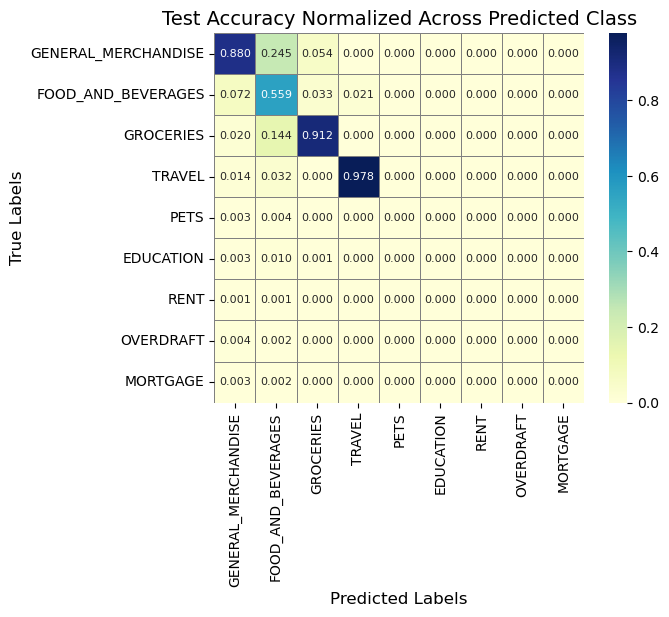

In [60]:
sns.heatmap(conf_matrix_df, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True,
            linewidths=0.5, linecolor='gray', square=True, annot_kws={"size": 8})

plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Test Accuracy Normalized Across Predicted Class", fontsize=14)
plt.show()

In [181]:
coef_df = pd.DataFrame(lr.coef_.T, columns=lr.classes_, index=X_train.columns)
coef_df.fillna(0, inplace=True)
coef_df.head()

,EDUCATION,FOOD_AND_BEVERAGES,GENERAL_MERCHANDISE,GROCERIES,MORTGAGE,OVERDRAFT,PETS,RENT,TRAVEL
amount,0.0040,0.0006,0.0040,0.0043,0.0042,-0.0287,0.0032,0.0041,0.0043
is_weekend,-0.0782,0.2241,0.1772,0.0630,-0.1146,-0.0285,-0.0635,-0.1212,-0.0583
is_even_amount,-0.0374,0.0059,0.4119,-0.1504,-0.0872,0.0091,-0.0385,-0.0866,-0.0268
day_of_week_0,-0.2175,0.6338,0.4553,0.2417,-0.3362,-0.0751,-0.1583,-0.3546,-0.1891
day_of_week_1,-0.1279,0.3430,0.3148,0.1169,-0.1965,-0.0379,-0.0972,-0.2041,-0.1110


In [182]:
coef_df.abs().idxmax(axis=0)

EDUCATION              day_of_week_0
FOOD_AND_BEVERAGES     day_of_week_0
GENERAL_MERCHANDISE       tfidf_bill
GROCERIES              tfidf_walmart
MORTGAGE               day_of_week_0
OVERDRAFT              day_of_week_0
PETS                   day_of_week_0
RENT                   day_of_week_0
TRAVEL                    tfidf_uber
dtype: object

In [183]:
rel_ftrs = coef_df.apply(lambda col: col.nlargest(5).index, axis=0)
rel_ftrs

,EDUCATION,FOOD_AND_BEVERAGES,GENERAL_MERCHANDISE,GROCERIES,MORTGAGE,OVERDRAFT,PETS,RENT,TRAVEL
0,amount,day_of_week_0,tfidf_bill,tfidf_walmart,amount,is_even_amount,amount,amount,tfidf_uber
1,month_num_0,tfidf_purchase,tfidf_amazon,tfidf_market,month_num_0,month_num_0,month_num_0,month_num_0,amount
2,bin_1,tfidf_mcdonald,tfidf_apple,day_of_week_0,bin_1,bin_1,bin_1,bin_1,month_num_0
3,bin_2,day_of_week_1,tfidf_cash,tfidf_target,bin_2,bin_2,bin_2,bin_2,bin_1
4,bin_3,day_of_week_4,day_of_week_0,tfidf_purchase,bin_3,bin_3,bin_3,bin_3,bin_2


In [184]:
coef_df.EDUCATION.loc[rel_ftrs.FOOD_AND_BEVERAGES.values]

day_of_week_0    -0.2175
tfidf_purchase   -0.1495
tfidf_mcdonald   -0.0369
day_of_week_1    -0.1279
day_of_week_4    -0.1126
Name: EDUCATION, dtype: float64

In [185]:
for col in coef_df.columns:
    print(col)
    print('\t' + str(', '.join(coef_df[col].nlargest(10).index)))

EDUCATION
	amount, month_num_0, bin_1, bin_2, bin_3, bin_4, bin_5, bin_6, bin_7, bin_8
FOOD_AND_BEVERAGES
	day_of_week_0, tfidf_purchase, tfidf_mcdonald, day_of_week_1, day_of_week_4, tfidf_authorized, tfidf_check, day_of_week_3, day_of_week_2, tfidf_checkca
GENERAL_MERCHANDISE
	tfidf_bill, tfidf_amazon, tfidf_apple, tfidf_cash, day_of_week_0, is_even_amount, tfidf_amzn, day_of_week_1, day_of_week_4, tfidf_dollar
GROCERIES
	tfidf_walmart, tfidf_market, day_of_week_0, tfidf_target, tfidf_purchase, day_of_week_1, day_of_week_4, day_of_week_2, day_of_week_3, month_num_8
MORTGAGE
	amount, month_num_0, bin_1, bin_2, bin_3, bin_4, bin_5, bin_6, bin_7, bin_8
OVERDRAFT
	is_even_amount, month_num_0, bin_1, bin_2, bin_3, bin_4, bin_5, bin_6, bin_7, bin_8
PETS
	amount, month_num_0, bin_1, bin_2, bin_3, bin_4, bin_5, bin_6, bin_7, bin_8
RENT
	amount, month_num_0, bin_1, bin_2, bin_3, bin_4, bin_5, bin_6, bin_7, bin_8
TRAVEL
	tfidf_uber, amount, month_num_0, bin_1, bin_2, bin_3, bin_4, bin_5, bin_6

# Evaluating Metric - F1-Scores

- **F1 Score < 0.5**: Poor performance. 
- **F1 Score between 0.5 and 0.6**: Below average performance. 
- **F1 Score between 0.6 and 0.7**: Average performance. 
- **F1 Score between 0.7 and 0.8**: Good performance. 
- **F1 Score between 0.8 and 0.9**: Very good performance. 
- **F1 Score >= 0.9**: Excellent performance. 

**_NOTE_** We have high class imbalance -- `weighted` f1 may be most relevant

In [258]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer

def f1_per_category(y_true, y_pred, avg='micro'):

    f1 = f1_score(y_true, y_pred, average=avg, zero_division=np.nan)
    return f1

In [264]:
f1_micro = f1_per_category(y_test, y_pred)
f1_macro = f1_per_category(y_test, y_pred, 'macro')
f1_weighted = f1_per_category(y_test, y_pred, 'weighted')

In [265]:
f1_micro

0.5568057609464412

In [266]:
f1_macro

0.14003640731417072

In [267]:
f1_weighted

0.48554590624540256

# Random Forest Model

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [43]:
X = model_ftrs.drop(columns=['category', 'amount'])  # Features (consider dropping amount)
y = model_ftrs['category']                 # Target

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [45]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [46]:
y_pred_rf = rf_model.predict(X_test)

In [47]:
rf_acc = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')

print(f"Random Forest - Accuracy: {rf_acc:.4f}, F1 Score: {rf_f1:.4f}")

Random Forest - Accuracy: 0.6883, F1 Score: 0.6789


#### History

- train: 50.01, test: 50.07
  - all features, tfidf = 50, original dates / amount ftrs

- train: 50.00, test: 49.97
  - all features, tfidf = 100, original_dates / amount ftrs

 - train: 52.93, test: 53.01
   - replaced scale with bins (test w/ w/o amount)
  
 - train: 55.58, test: 55.68
   - improved cleaning, bins, tfidf = 100 - grabbed top 25 || EXCLIDING AMOUNT =>

- train: 68, test: 68
   - dropped amount, bins, tfidf = 100, grapped top 25

## Checking Distribution of Overall and Training Data

In [75]:
original_data = relevant_of.category.value_counts(normalize=True)
original_data

category
GENERAL_MERCHANDISE   0.4011
FOOD_AND_BEVERAGES    0.3689
GROCERIES             0.1679
TRAVEL                0.0457
PETS                  0.0071
EDUCATION             0.0034
OVERDRAFT             0.0026
RENT                  0.0024
MORTGAGE              0.0009
Name: proportion, dtype: float64

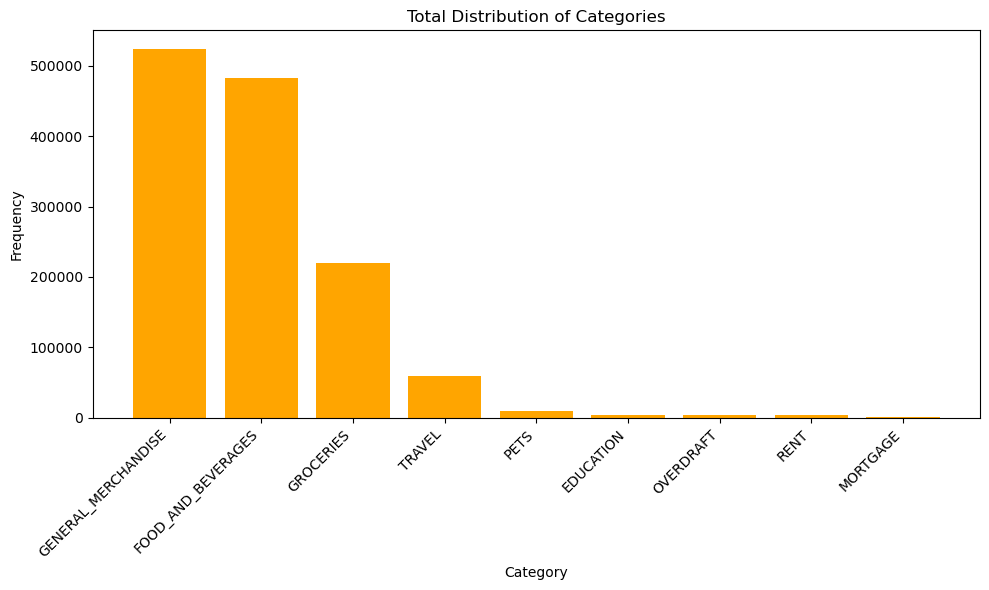

In [63]:
plt.figure(figsize=(10, 6))
plt.bar(original_data.index, original_data.values, color='orange')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('Total Distribution of Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [74]:
train_data = y_train.value_counts(normalize=True)
train_data

category
GENERAL_MERCHANDISE   0.4008
FOOD_AND_BEVERAGES    0.3691
GROCERIES             0.1679
TRAVEL                0.0458
PETS                  0.0071
EDUCATION             0.0034
OVERDRAFT             0.0026
RENT                  0.0024
MORTGAGE              0.0008
Name: proportion, dtype: float64

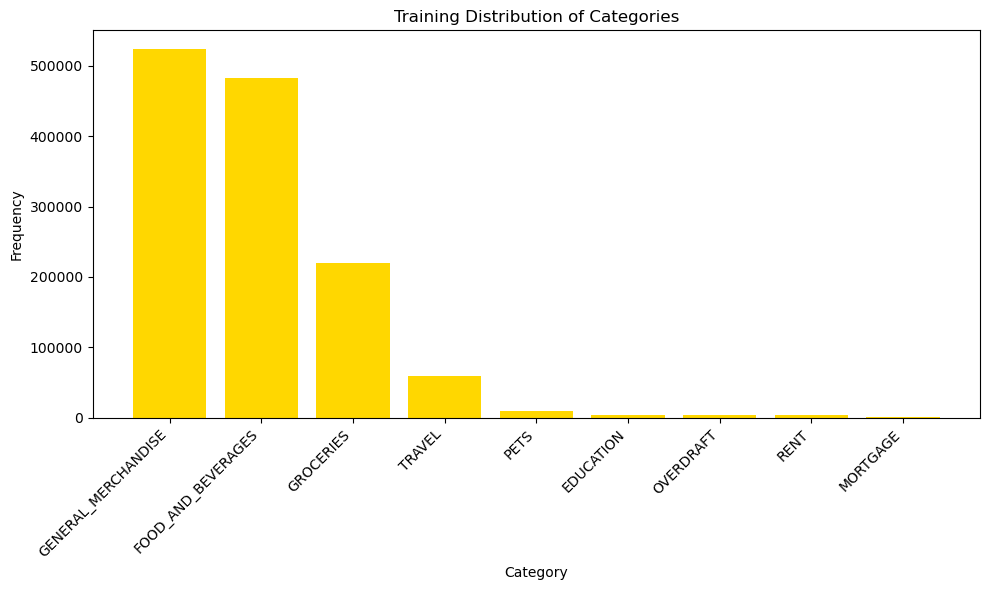

In [65]:
plt.figure(figsize=(10, 6))
plt.bar(original_data.index, original_data.values, color='gold')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('Training Distribution of Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Determining Feature Importance

A. By feature coefficients <br>
B. Recursive Feature Elimination


In [48]:
imp_ftrs = pd.DataFrame({'feature': X.columns, 'coefficient': abs(lr.coef_[0])})
imp_ftrs = imp_ftrs.sort_values(by='coefficient', ascending=False).reset_index(drop=True)

print(imp_ftrs.shape)
imp_ftrs.head(10)

(57, 2)


,feature,coefficient
0,tfidf_on,$0.16
1,day_of_week_0,$0.16
2,tfidf_purchase,$0.10
3,amount,$0.10
4,day_of_week_1,$0.09
5,day_of_week_4,$0.08
6,day_of_week_3,$0.07
7,day_of_week_2,$0.07
8,tfidf_authorized,$0.06
9,is_weekend,$0.06


In [49]:
ftr_imp_10 = model_ftrs[np.append(imp_ftrs.iloc[:10].feature.values, ['category'])]
ftr_imp_10

,tfidf_on,day_of_week_0,tfidf_purchase,amount,day_of_week_1,day_of_week_4,day_of_week_3,day_of_week_2,tfidf_authorized,is_weekend,category
0,0,1,0,$18.42,0,0,0,0,0,0,FOOD_AND_BEVERAGES
1,0,1,0,$26.47,0,0,0,0,0,0,FOOD_AND_BEVERAGES
2,0,1,0,$11.73,0,0,0,0,0,0,GENERAL_MERCHANDISE
3,0,0,0,$30.04,0,0,0,1,0,0,FOOD_AND_BEVERAGES
4,0,0,0,$4.16,1,0,0,0,0,0,GENERAL_MERCHANDISE
...,...,...,...,...,...,...,...,...,...,...,...
1306447,1,1,1,$15.93,0,0,0,0,0,0,GENERAL_MERCHANDISE
1306448,0,0,0,$25.00,0,0,0,1,0,0,EDUCATION
1306449,0,0,0,$3.68,0,0,0,1,0,0,FOOD_AND_BEVERAGES
1306450,1,0,0,$90.00,0,1,0,0,0,0,FOOD_AND_BEVERAGES


In [14]:
X_sub1 = model_ftrs.drop(columns=['category'])  # Features
y_sub1 = model_ftrs['category']                 # Target

In [15]:
X_sub1_train, X_sub1_test, y_sub1_train, y_sub1_test = train_test_split(X_sub1, y_sub1, test_size=0.25, random_state=42)

In [16]:
lr_sub1 = LogisticRegression(max_iter=100, random_state=42)  # Increase max_iter if needed
lr_sub1.fit(X_sub1_train, y_sub1_train)


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [17]:
y_sub1_pred = lr_sub1.predict(X_sub1_test)
y_sub1_pred[:10]

array(['FOOD_AND_BEVERAGES', 'FOOD_AND_BEVERAGES', 'FOOD_AND_BEVERAGES',
       'FOOD_AND_BEVERAGES', 'FOOD_AND_BEVERAGES', 'FOOD_AND_BEVERAGES',
       'FOOD_AND_BEVERAGES', 'FOOD_AND_BEVERAGES', 'GENERAL_MERCHANDISE',
       'FOOD_AND_BEVERAGES'], dtype=object)

In [18]:
test_acc_sub1 = (y_sub1_test == y_sub1_pred).mean()
test_acc_sub1

0.5300860651596844

In [28]:
y_sub1_pred_train = lr_sub1.predict(X_sub1_train)
train_acc_sub1 = (y_sub1_train == y_sub1_pred_train).mean()
train_acc_sub1

0.5292971600436398

In [37]:
checks = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True), pd.Series(y_sub1_pred_train, name='predictions')], axis=1)
checks.head()

,amount,is_weekend,is_even_amount,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,...,tfidf_market,tfidf_check,tfidf_eleven,tfidf_target,tfidf_starbucks,tfidf_dollar,tfidf_payment,tfidf_doordash,category,predictions
0,$186.37,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,FOOD_AND_BEVERAGES,FOOD_AND_BEVERAGES
1,"$1,437.88",0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,FOOD_AND_BEVERAGES,GENERAL_MERCHANDISE
2,$11.63,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,FOOD_AND_BEVERAGES,FOOD_AND_BEVERAGES
3,$2.99,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,GENERAL_MERCHANDISE,GENERAL_MERCHANDISE
4,$26.69,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,GROCERIES,FOOD_AND_BEVERAGES


In [39]:
wrongs = checks[checks.category != checks.predictions]

wrongs.category.value_counts()

category
GENERAL_MERCHANDISE    221389
GROCERIES              164550
TRAVEL                  44844
FOOD_AND_BEVERAGES      14365
PETS                     6949
EDUCATION                3373
OVERDRAFT                2585
RENT                     2339
MORTGAGE                  819
Name: count, dtype: int64

In [41]:
model_ftrs.category.value_counts()

category
GENERAL_MERCHANDISE    524063
FOOD_AND_BEVERAGES     481994
GROCERIES              219331
TRAVEL                  59647
PETS                     9266
EDUCATION                4499
OVERDRAFT                3386
RENT                     3147
MORTGAGE                 1119
Name: count, dtype: int64